In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Imports

In [2]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

Dataset

Loading contents from file...


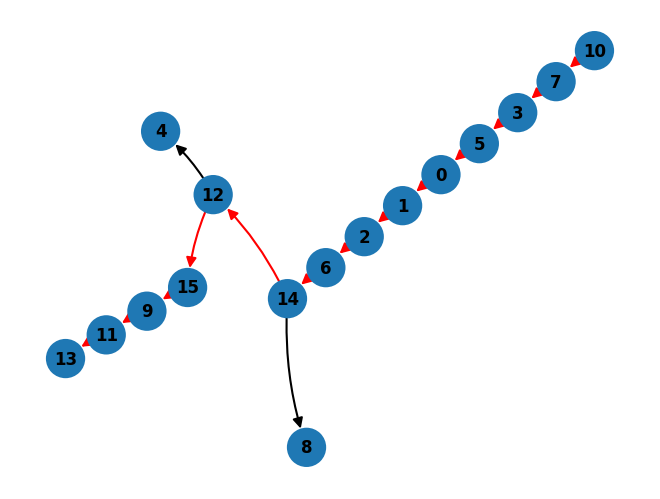

In [3]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

Model

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

Cache Activations

In [5]:
#act_names = ["ln_final.hook_normalized"]
#act_names += [f"blocks.{i}.ln2.hook_normalized" for i in range(model.cfg.n_layers)]
act_names = [f"blocks.{i}.hook_resid_post" for i in range(model.cfg.n_layers)]
#act_names += [f"blocks.{i}.mlp.hook_post" for i in range(model.cfg.n_layers)]

model.reset_hooks()

activations_file = "activations_resid_only_64k.pt"
if not os.path.exists(activations_file):
    print("Generating activations ...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=64_000,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , activations_file)
else:
    print("loading activations ... ")
    acts, graphs, test_acts, test_graphs = torch.load(activations_file)

loading activations ... 


In [6]:
from feature_utils import return_probing_dataset


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

In [7]:
dataX.keys()

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post'])

SAE

In [19]:
# note: increasing sae dim beyond d_model might not be necessary here, as the model might not need more in our synthetic task. If our current sae is weird, we might study how different sae dims affect the reconstruction loss

In [7]:
from sparse_coding import *

d_model = dataX['blocks.4.hook_resid_post'].shape[-1]
sae = SparseCoder(num_codes=4*d_model, verbose=True)

In [ ]:
# train
sae.fit(dataX['blocks.5.ln2.hook_normalized'])
torch.save(sae.model.state_dict(), f'sae.pt')

In [8]:
# load
checkpoint = torch.load('sae_resid_post_4.pt')
sae.construct_model(128)
sae.model.load_state_dict(checkpoint)
sae.model.to('cuda')

SparseAutoencoder()

SAE Evaluations

In [46]:
# Evaluation: Use reconstructed activations in the model and see how bad it gets

from functools import partial
import random

def eval_model(model, dataset, test_graph):
    model.eval()
    
    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 2
    curr_idx = start_idx

    flag = False
    while not flag and curr_idx < dataset.max_seq_length - 1:
        # Convert to pytorch
        input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
        input_tokens[curr_idx:] = 0
        input_tokens = input_tokens.unsqueeze(0)[:, :-1]
        # Run model
        with torch.no_grad():
            outputs = model(input_tokens).argmax(-1)
            pred = outputs[0, curr_idx-1]
            test_graph_tokens[curr_idx] = pred.item()
            if pred.item() == dataset.pad_token:  # Check if we reached the goal
                flag = True
        curr_idx += 1

    final_path = dataset.untokenize(test_graph_tokens[:curr_idx])
    
    first_move_correct = dataset.tokenize(test_graph)[48] == dataset.tokenize(final_path)[48]
    return final_path, test_graph == final_path, first_move_correct


def add_sae_hook(layer):

    def sae_hook(
            acts,
            hook):
        b, c, d = acts.shape  # e.g. [1, 65, 128]
        f, r = sae.model(acts)
        acts[:, 47, :] = r[:, 47, :]
        return acts

    temp_hook_fn_sae = partial(sae_hook)
    model.blocks[layer].hook_resid_post.add_hook(temp_hook_fn_sae)

def add_delete_position_hook(layer, position):

    def delete_position_hook(
            acts,
            hook):
        acts[:, position, :] = torch.mean(acts[:, position, :])
        return acts

    temp_hook_fn_del = partial(delete_position_hook)
    model.blocks[layer].hook_resid_post.add_hook(temp_hook_fn_del)


def run_eval():
    for order in ["forward", "backward", "random"]:
        total_correct = 0
        total_first_correct = 0
        for _ in range(num_samples):
            graph = generate_example(16, random.randint(0, 1000000), order=order)
            pred, correct, first_correct = eval_model(model, dataset, graph)
            if first_correct:
                total_first_correct += 1      

        print(f"Layer {layer}, With Hook {order}: {100* total_first_correct / num_samples:.4f}%")


for layer in range(4, 6):
    start_seed = 450_000
    num_samples = 100


    #model.reset_hooks()
    #run_eval()


    #model.reset_hooks()
    #add_sae_hook(layer)
    #run_eval()

    # to check whether the position 47 information is actually important, we should check what happens if we knock them out
    model.reset_hooks()
    add_delete_position_hook(layer, 47)
    run_eval()


Layer 4, With Hook forward: 8.0000%
Layer 4, With Hook backward: 4.0000%
Layer 4, With Hook random: 5.0000%
Layer 5, With Hook forward: 9.0000%
Layer 5, With Hook backward: 4.0000%
Layer 5, With Hook random: 7.0000%


Visualizations

In [14]:
def get_learned_dict(sae):
    norms = torch.norm(sae.model.W_e, 2, dim=-1)
    return sae.model.W_e / torch.clamp(norms, 1e-8)[:, None]

dict = get_learned_dict(sae)

In [15]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange

from feature_utils import get_dictionary_activations

max_seq_length = dataset.max_seq_length - 1
device = 'cuda'
sae.model.to(device)


print("Getting dictionary activations")
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, 'blocks.5.ln2.hook_normalized', sae, max_seq_length, batch_size=32)

Getting dictionary activations


  0%|          | 0/9375 [00:00<?, ?it/s]

In [ ]:
# look at feature density / look at features which activate a lot / highly affect logits

In [ ]:
from feature_utils import get_feature_indices, get_feature_datapoints

feature = 5
num_feature_datapoints = 5000
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)

print(f"Feature {feature}: {len(text_list)}")

merged = [list(a) for a in zip(full_text, local_activations)]
def sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li
merged_sorted = sort(merged)
subset = merged_sorted[-20:]

for graph, activation in subset:
    print(graph)
    parse_example(graph)
    plt.show()

Print Examples for all Features

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image

def fixed_plot(strings):
    G = nx.Graph()
    for s in strings:
        nodes = s.split('-')
        G.add_edge(nodes[0], nodes[1])
    nx.draw(G, with_labels=True)
    plt.axis('off')

def save_plots_as_images(strings_list, filenames):
    for idx, strings in enumerate(strings_list):
        parse_example(strings)
        plt.savefig(filenames[idx])
        plt.close()

def concat_images_vertically(filenames):
    images = [Image.open(filename) for filename in filenames]
    total_width = max(im.width for im in images)
    total_height = sum(im.height for im in images)
    new_image = Image.new('RGB', (total_width, total_height))
    
    y_offset = 0
    for im in images:
        new_image.paste(im, (0, y_offset))
        y_offset += im.height
    return new_image

num_feature_datapoints = 5000
import os
import json

# make features/ dir if not exist
save_path = "feature_examples/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

for feature in range(512):
    
    # sample examples that activate feature
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
    print(f"Feature {feature}: {len(text_list)}")

    if len(text_list) > 0:

        if len(text_list) > 20:
            # sample the 20 most interesting ones
            merged = [list(a) for a in zip(full_text, local_activations)]
            def sort(sub_li):
                sub_li.sort(key = lambda x: x[1])
                return sub_li
            merged_sorted = sort(merged)
            subset = merged_sorted[-20:]
            full_text = [s[0] for s in subset]

        # generate plots    
        filenames = [f"temp_plot_{i}.png" for i in range(len(full_text))]    
        save_plots_as_images(full_text, filenames)
        concatenated_image = concat_images_vertically(filenames)

        # Save concatenated image as a PDF
        concatenated_image.save(os.path.join(save_path, f'feature_{feature}.pdf'), "PDF", resolution=100.0)

        # Optionally, delete temp images
        for filename in filenames:
            import os
            os.remove(filename)


/tmp/ipykernel_1188235/1063462403.py:20: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0: 0
Feature 1: 0
Feature 2: 0


/tmp/ipykernel_1188235/1063462403.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md][0])


Feature 3: 186
Feature 4: 875
Feature 5: 266
Feature 6: 0
Feature 7: 1
Feature 8: 151
Feature 9: 39
Feature 10: 736
Feature 11: 26
Feature 12: 0
Feature 13: 261
Feature 14: 175
Feature 15: 0
Feature 16: 187
Feature 17: 32
Feature 18: 0
Feature 19: 773
Feature 20: 0
Feature 21: 0
Feature 22: 334
Feature 23: 0
Feature 24: 0
Feature 25: 1383
Feature 26: 0
Feature 27: 314
Feature 28: 576
Feature 29: 222
Feature 30: 0
Feature 31: 670
Feature 32: 0
Feature 33: 724
Feature 34: 0
Feature 35: 39
Feature 36: 0
Feature 37: 3
Feature 38: 0
Feature 39: 5
Feature 40: 0
Feature 41: 420
Feature 42: 0
Feature 43: 0
Feature 44: 0
Feature 45: 0
Feature 46: 0
Feature 47: 0
Feature 48: 0
Feature 49: 0
Feature 50: 597
Feature 51: 0
Feature 52: 129
Feature 53: 0
Feature 54: 257
Feature 55: 0
Feature 56: 0
Feature 57: 0
Feature 58: 14
Feature 59: 15
Feature 60: 0
Feature 61: 0
Feature 62: 0
Feature 63: 510
Feature 64: 0
Feature 65: 0
Feature 66: 53
Feature 67: 1
Feature 68: 0
Feature 69: 898
Feature 70: 60
Fe

Study Activations on One Specific Example

In [28]:
example = 
example = dataset.tokenize(example)
batch_size = 1
cache_name = 'blocks.4.hook_resid_post'
i = 0

input_tokens = torch.from_numpy(example).to(torch.long).cuda()
input_tokens = input_tokens.unsqueeze(0)[:, :-1]

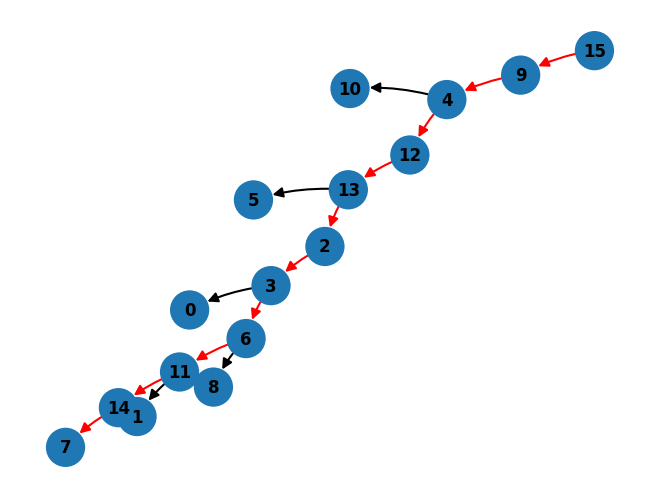

In [63]:
parse_example("4>10,3>0,14>7,2>3,3>6,11>14,13>5,4>12,12>13,6>11,9>4,11>1,13>2,6>8,15>9|7:15>9>4>12>13>2>3>6>11>14>7")

In [38]:
# get activated features

num_features, d_model = sae.model.W_e.shape
datapoints = len(example)
dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
batch = input_tokens.to(device)
token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
_, cache = model.run_with_cache(batch.to(device))
batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
batched_dictionary_activations, _ = sae.model(batched_neuron_activations.cuda())

In [49]:
sum(batched_dictionary_activations[47, :] > 0.01)

tensor(111, device='cuda:0')

In [64]:
# feature knockout

from functools import partial

def eval_model(model, dataset, test_graph):
    model.eval()
    
    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 2
    curr_idx = start_idx

    flag = False
    while not flag and curr_idx < dataset.max_seq_length - 1:
        # Convert to pytorch
        input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
        input_tokens[curr_idx:] = 0
        input_tokens = input_tokens.unsqueeze(0)[:, :-1]
        # Run model
        with torch.no_grad():
            outputs = model(input_tokens).argmax(-1)
            pred = outputs[0, curr_idx-1]
            test_graph_tokens[curr_idx] = pred.item()
            if pred.item() == dataset.pad_token:  # Check if we reached the goal
                flag = True
        curr_idx += 1

    final_path = dataset.untokenize(test_graph_tokens[:curr_idx])
    
    first_move_correct = dataset.tokenize(test_graph)[48] == dataset.tokenize(final_path)[48]
    return final_path, test_graph == final_path, first_move_correct


def add_feature_knockout_hook(layer, position, feature):

    # Add low-rank hook
    def feature_knockout(
            acts,
            hook):
        
        # SAE encoder
        x_bar = acts - sae.model.b_d
        features = F.relu(torch.matmul(x_bar, sae.model.W_e.T) + sae.model.b_e)

        # feature knockout / ablations (feature shape [batch, seq_len, features] ??)
        features[:, position, feature] = 0

        # SAE decoder
        W_d = F.normalize(sae.model.W_d, dim=1, p=2)
        reconstruction = torch.matmul(features, W_d.T) + sae.model.b_d

        # replace the activations of selected position
        acts[:, position, :] = reconstruction[:, position, :]
        return acts

    temp_hook_fn = partial(feature_knockout)
    model.blocks[layer].hook_resid_post.add_hook(temp_hook_fn)

features_that_change_prediction = []

example = "4>10,3>0,14>7,2>3,3>6,11>14,13>5,4>12,12>13,6>11,9>4,11>1,13>2,6>8,15>9|7:15>9>4>12>13>2>3>6>11>14>7"
for f_id, f_act in enumerate(batched_dictionary_activations[47, :]):
    if f_act > 0.01:

        model.reset_hooks()
        add_feature_knockout_hook(4, 47, f_id)

        pred, correct, first_correct = eval_model(model, dataset, example)
        if not first_correct:
            print(f"Feature {f_id} | Is Correct: {first_correct} | Prediction: {pred}")

Feature 338 | Is Correct: False | Prediction: 4>10,3>0,14>7,2>3,3>6,11>14,13>5,4>12,12>13,6>11,9>4,11>1,13>2,6>8,15>9|7:15>15>9>4>12>13>2>3>6>11>14>7
Feature 486 | Is Correct: False | Prediction: 4>10,3>0,14>7,2>3,3>6,11>14,13>5,4>12,12>13,6>11,9>4,11>1,13>2,6>8,15>9|7:15>4>12>13>2>3>6>11>14>7


In [68]:
feature = 486

In [66]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange

max_seq_length = dataset.max_seq_length - 1
device = 'cuda'
sae.model.to(device)
def get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32):
    num_features, d_model = autoencoder.model.W_e.shape
    datapoints = len(dataset)
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad():
        dl = DataLoader(dataset, batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            batch = batch[0][:, :-1].to(device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            batched_dictionary_activations, _ = autoencoder.model(batched_neuron_activations.cuda())
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list

print("Getting dictionary activations")
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, 'blocks.5.ln2.hook_normalized', sae, batch_size=32)

Getting dictionary activations


  0%|          | 0/9375 [00:00<?, ?it/s]

KeyboardInterrupt: 

/tmp/ipykernel_1142366/1063462403.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md][0])


Feature 486: 618
3>4,0>5,11>14,5>11,5>13,9>0,9>10,7>8,10>3,12>2,0>7,13>15,3>6,12>9,10>1|1:12>9>10>1


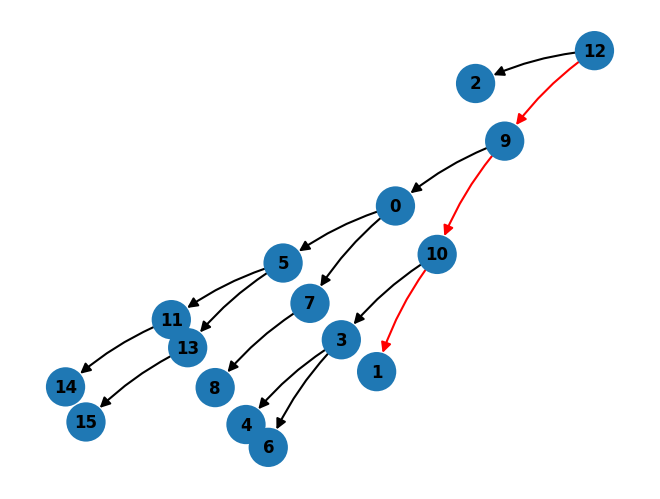

1>3,10>13,0>1,4>5,0>2,3>8,9>4,9>0,7>12,4>14,15>7,5>6,7>10,8>11,15>9|14:15>9>4>14


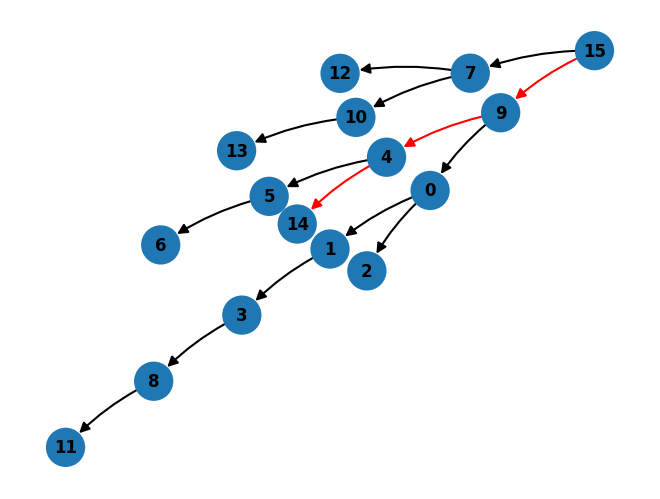

3>7,1>2,9>14,11>5,6>10,1>11,14>6,4>15,0>12,4>8,11>3,7>13,14>1,0>9,9>4|5:0>9>14>1>11>5


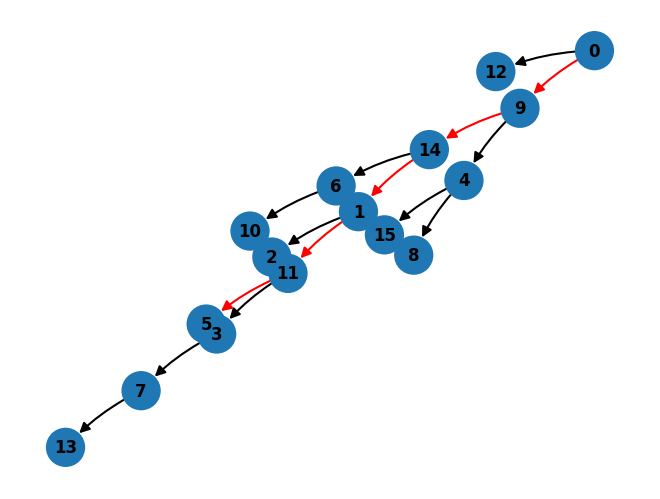

7>3,0>4,3>15,4>6,12>7,4>10,10>11,9>12,1>13,6>14,7>5,9>0,12>1,2>9,0>8|5:2>9>12>7>5


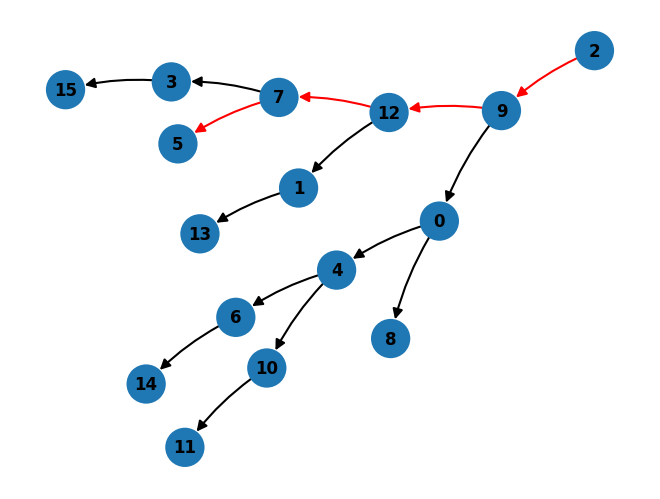

12>3,1>2,1>0,5>13,3>10,0>4,9>5,4>7,4>6,5>8,13>14,3>15,6>11,9>1,12>9|2:12>9>1>2


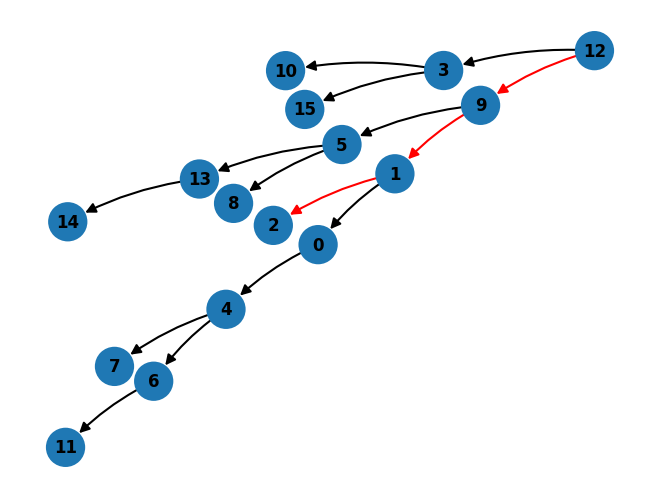

5>7,6>14,0>2,11>3,11>10,15>12,9>15,9>1,3>8,0>9,2>5,15>11,3>13,1>4,1>6|10:0>9>15>11>10


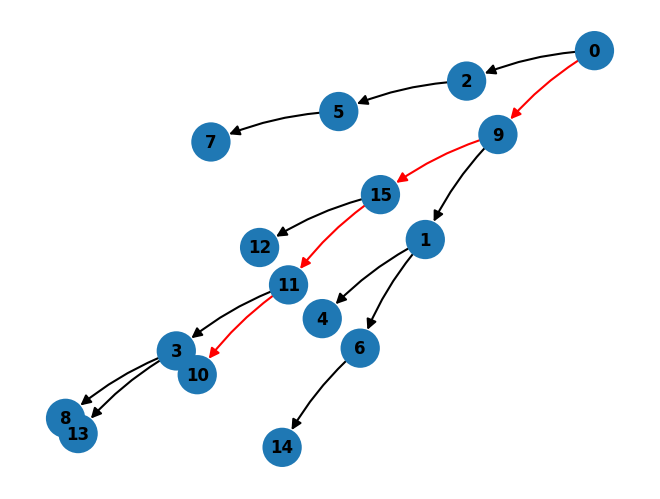

7>11,1>8,9>0,1>6,3>12,0>3,4>15,8>10,0>2,11>13,5>1,9>4,13>14,5>9,6>7|15:5>9>4>15


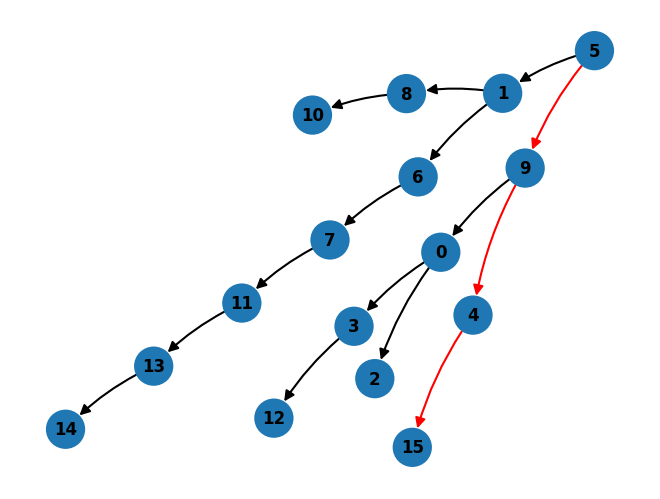

5>0,8>12,9>15,2>6,0>10,15>3,2>4,1>7,6>11,15>14,6>13,5>9,9>1,1>2,4>8|14:5>9>15>14


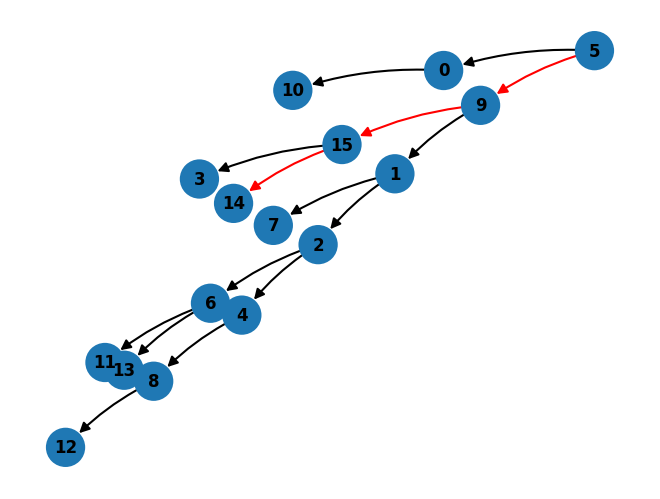

9>0,1>2,2>15,3>4,3>12,5>14,13>10,0>1,9>13,2>7,0>11,5>9,13>6,7>8,1>3|6:5>9>13>6


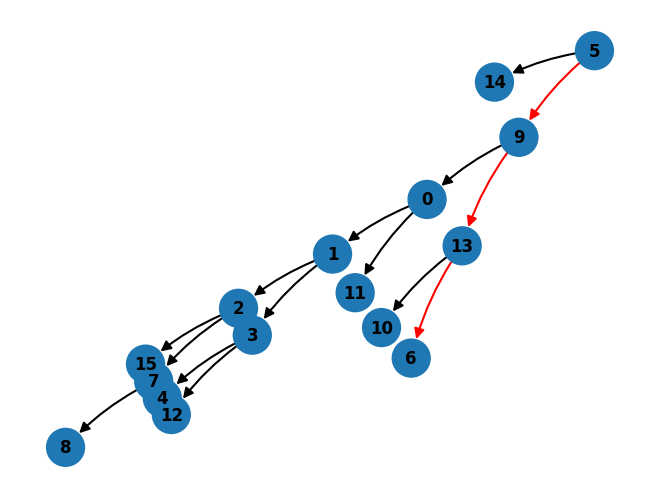

3>10,5>8,0>4,11>14,9>1,5>12,4>6,4>7,0>13,3>5,9>0,13>15,1>3,1>2,11>9|15:11>9>0>13>15


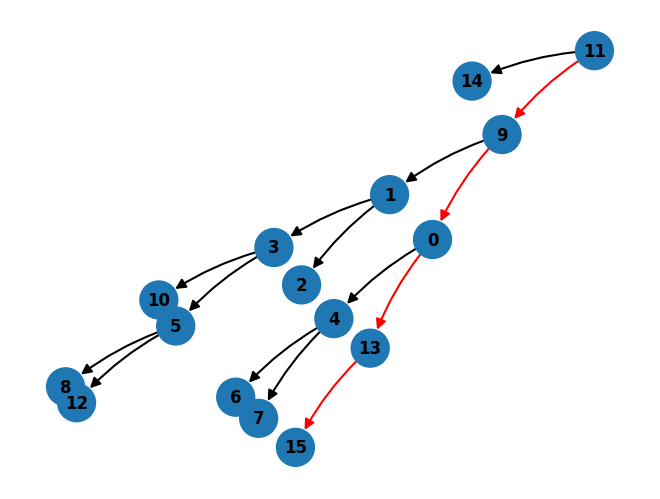

4>7,3>13,0>8,12>2,4>6,1>14,2>5,8>10,9>0,1>4,2>3,8>15,12>1,11>9,9>12|14:11>9>12>1>14


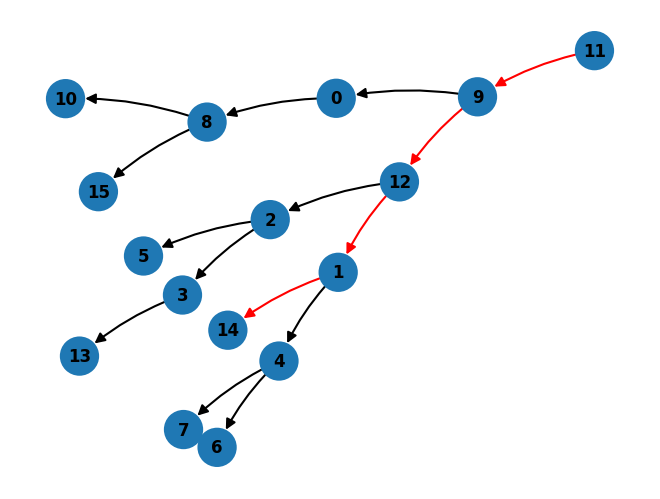

10>15,2>10,5>1,9>0,3>14,3>8,0>6,11>4,7>12,9>11,8>13,5>9,11>2,2>7,0>3|4:5>9>11>4


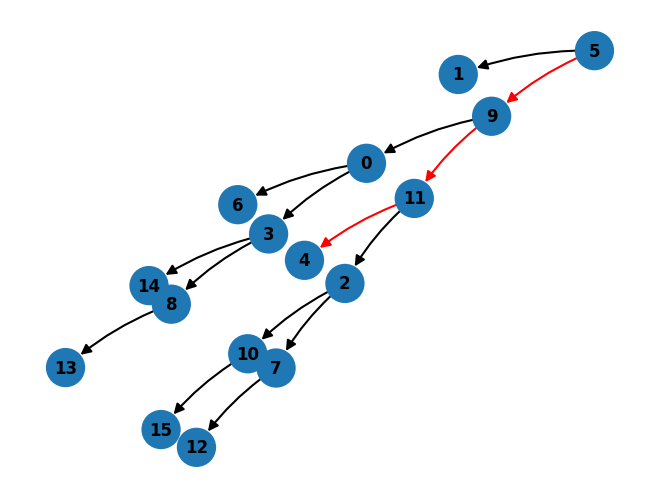

9>14,3>8,5>0,14>1,12>13,6>12,2>7,1>11,2>3,0>6,14>4,10>15,7>10,9>2,5>9|4:5>9>14>4


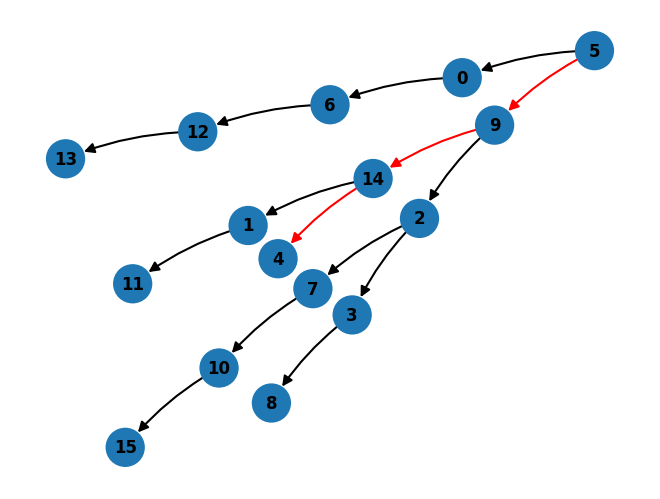

0>13,4>14,1>6,9>1,9>2,2>3,7>15,5>0,3>12,2>10,0>8,4>7,1>4,5>9,7>11|6:5>9>1>6


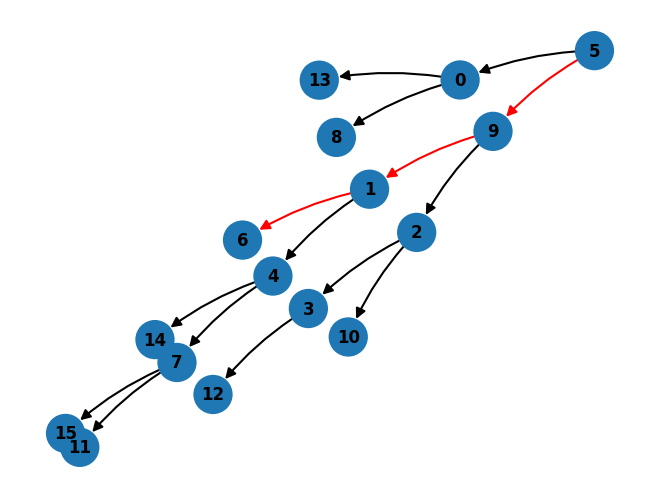

15>0,14>1,9>7,8>12,3>5,10>15,1>4,9>14,6>13,7>8,15>11,1>2,14>10,2>3,6>9|11:6>9>14>10>15>11


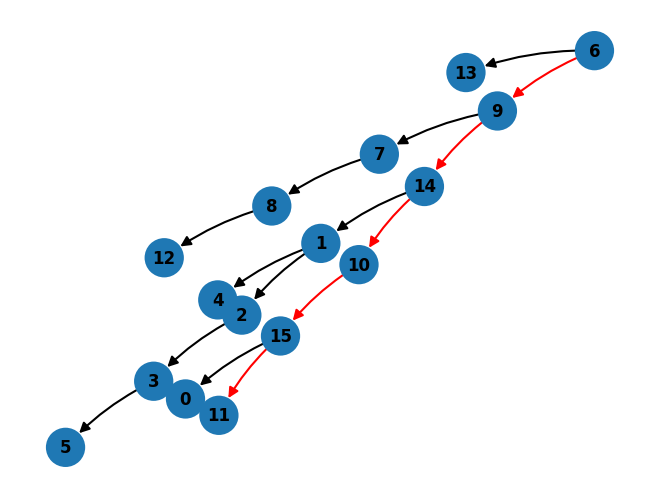

7>10,7>4,2>8,5>11,8>15,6>14,2>3,9>6,6>12,9>5,11>7,11>13,5>1,0>2,0>9|4:0>9>5>11>7>4


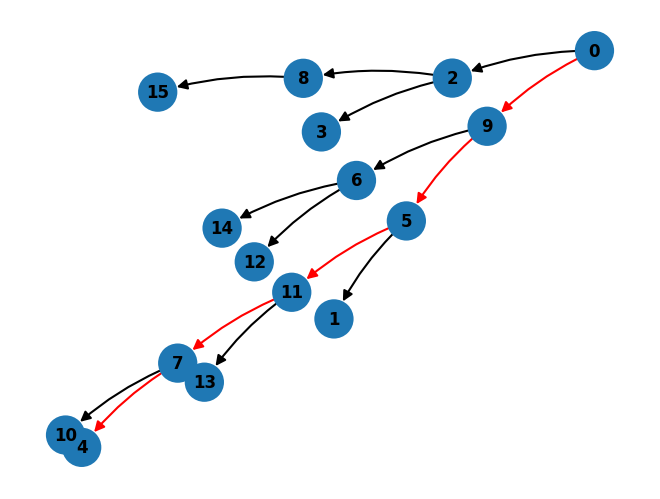

11>3,2>5,0>4,2>6,1>13,9>2,5>10,11>15,9>1,7>14,1>11,7>12,5>7,4>8,0>9|15:0>9>1>11>15


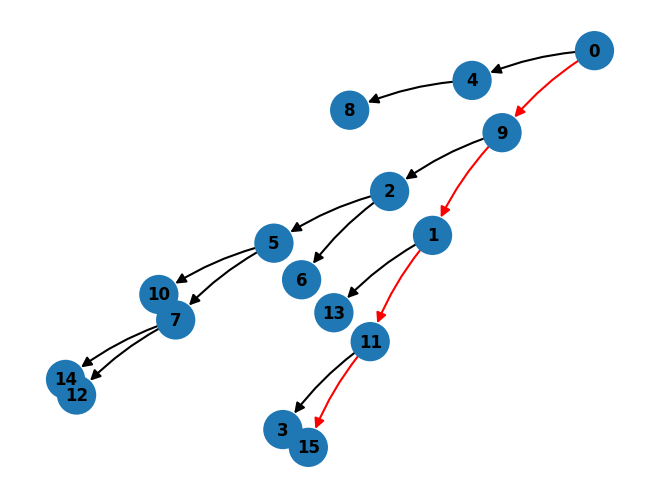

13>4,5>7,0>10,9>2,3>14,1>12,13>5,9>0,8>15,2>3,1>13,3>8,0>1,6>11,6>9|4:6>9>0>1>13>4


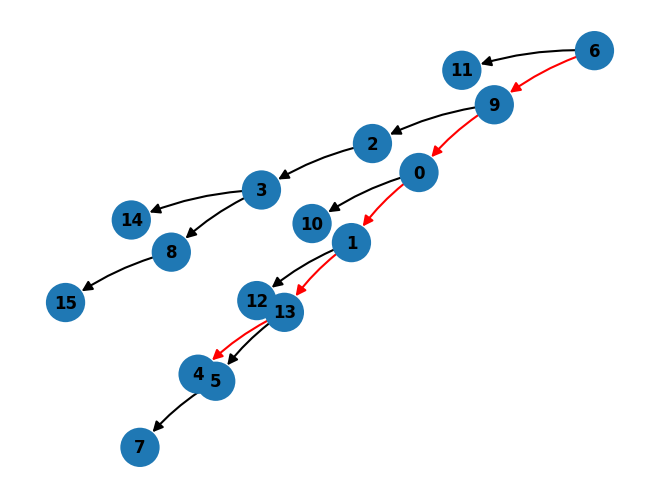

15>7,4>5,15>1,7>8,1>4,7>3,4>6,6>13,0>2,1>10,9>15,9>14,5>11,0>9,5>12|3:0>9>15>7>3


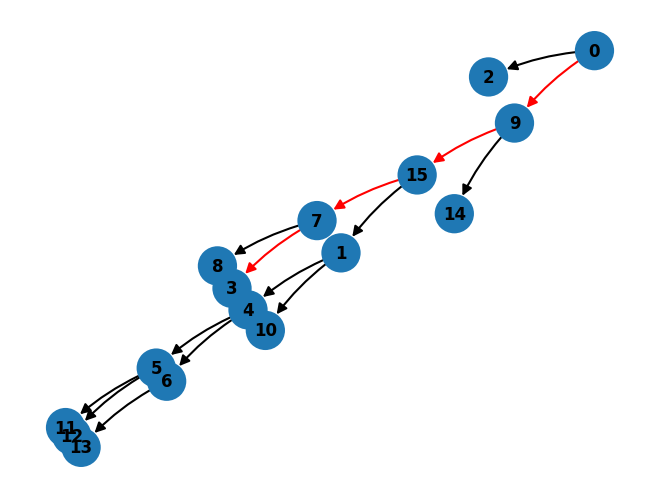

9>4,1>2,15>1,3>0,12>13,5>14,7>10,8>12,4>7,7>8,3>6,4>11,9>15,5>9,15>3|6:5>9>15>3>6


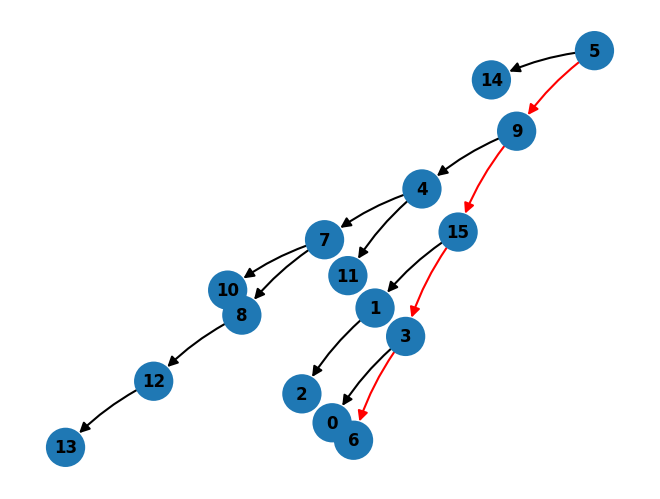

In [69]:
num_feature_datapoints = 5000
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)

print(f"Feature {feature}: {len(text_list)}")

merged = [list(a) for a in zip(full_text, local_activations)]
def sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li
merged_sorted = sort(merged)
subset = merged_sorted[-20:]

for graph, activation in subset:
    print(graph)
    parse_example(graph)
    plt.show()

In [31]:
dictionary_activations.shape

torch.Size([4290, 512])

In [ ]:
dictionary_activations, tokens_for_each_datapoint

In [17]:
tokens_for_each_datapoint.shape

torch.Size([19500000])

In [15]:
dictionary_activations.shape

torch.Size([19500000, 512])

In [ ]:
example = 

Other Stuff

In [12]:
num_features, d_model = sae.model.W_e.shape
num_features

512

In [ ]:
# we know that feature 4 is a "11 is two steps away from the goal position" feature. 

important_features = {}  # > 50 activations
eleven_two_steps_away = []  # "11 is two steps away from the goal position" features

import os
import json

# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 5000

# features
for feature in range(num_features):
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
    if len(text_list) > 50: 
        is_eleven_is_two_steps_from_goal_feature = sum([f.split(">")[-3] == "11" for f in full_text]) / len([f.split(">")[-3] == "11" for f in full_text]) > 0.5
        outputs = {
            "feature": feature,
            "is_eleven_is_two_steps_from_goal_feature": is_eleven_is_two_steps_from_goal_feature,
            "text_list": text_list,
            "full_text": full_text, 
            "token_list": [t.clone().detach().numpy().tolist() for t in token_list], 
            "full_token_list": [t.clone().detach().numpy().tolist() for t in full_token_list],
            "partial_activations": partial_activations,
            "full_activations": full_activations, 
            "local_activations": local_activations
        }
        important_features[feature] = outputs
        with open(os.path.join(save_path, f"feature_{feature}.json"), 'w') as f:
            json.dump(outputs, f)
        
        print(f"Feature {feature} | Important ({len(text_list)}) | Is 11 is 2 Steps from Goal Feature: {is_eleven_is_two_steps_from_goal_feature}")
    else:
        print(f"Feature {feature} | Not Important ({len(text_list)})")

In [19]:
feature = 5
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
print(f"Feature {feature}: {len(text_list)}")

merged = [list(a) for a in zip(full_text, local_activations)]
def sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li
merged_sorted = sort(merged)
subset = merged_sorted[-20:]

for graph, activation in subset:
    print(graph)
    parse_example(graph)
    plt.show()

NameError: name 'num_feature_datapoints' is not defined

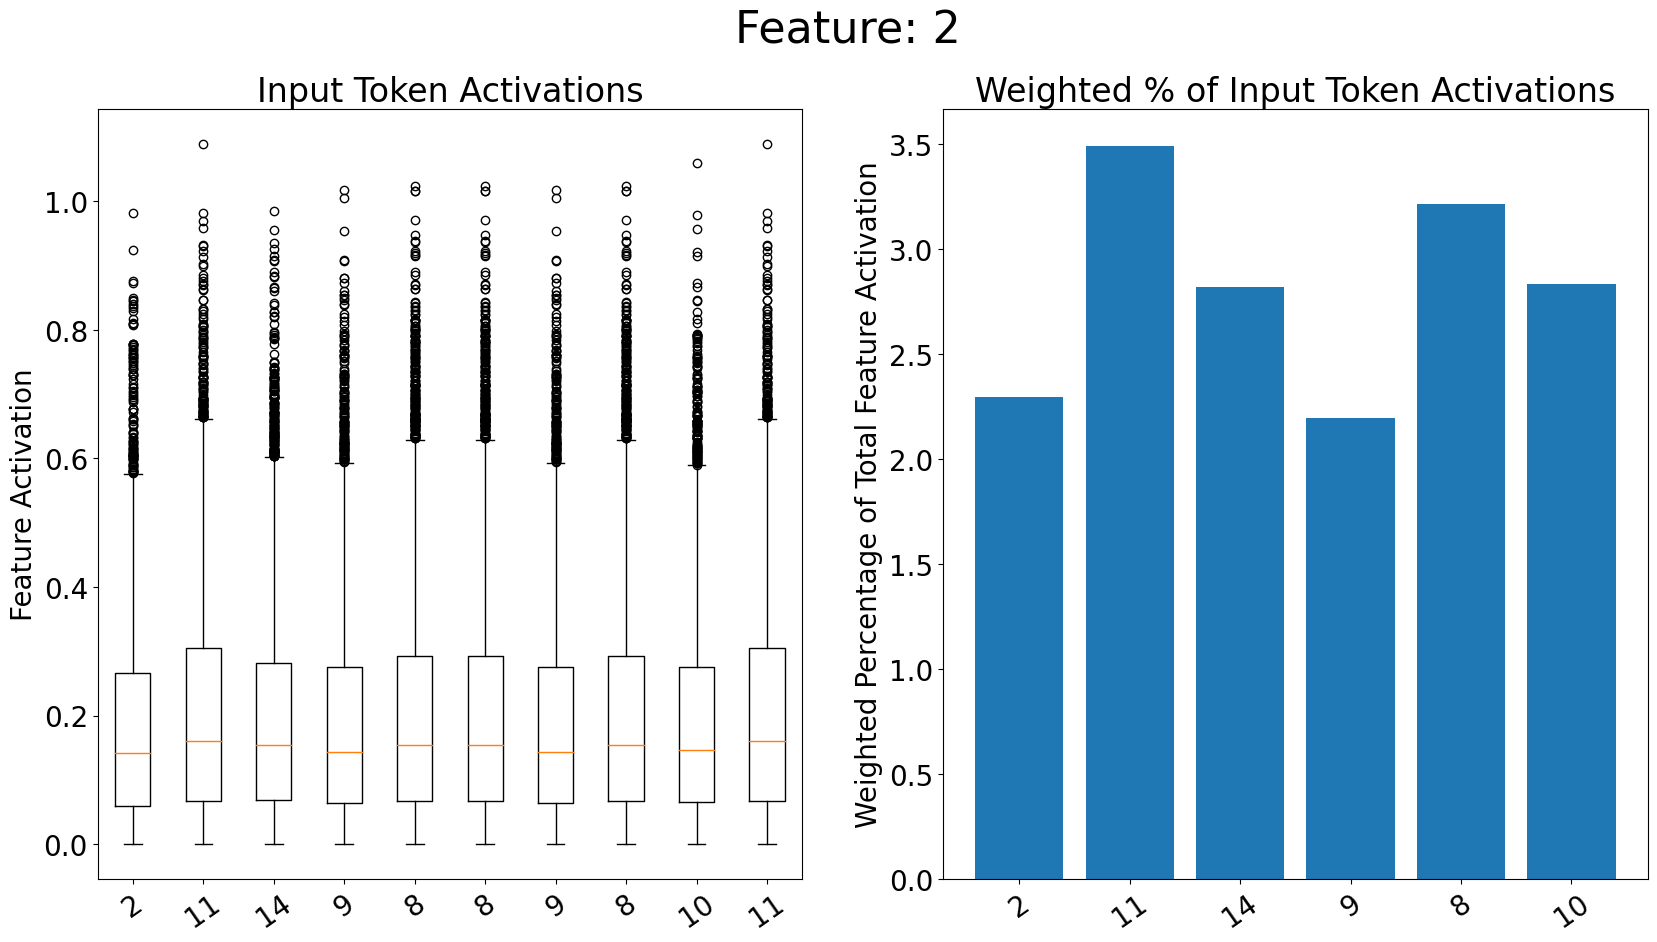

In [14]:
def get_token_statistics(feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location="", num_unique_tokens=10, setting="input", negative_threshold=-0.01):
    if(setting=="input"):
        nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
    else:
        nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
    nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

    # Unravel the indices to get the token IDs
    datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]
    all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

    # Find the max value for each unique token
    token_value_dict = defaultdict(int)
    for token, value in zip(all_tokens, nonzero_values):
        token_value_dict[token] = max(token_value_dict[token], value)
    # if(setting=="input"):
    sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
    # else:
    #     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
    # Take the top 10 (or fewer if there aren't 10)
    max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
    total_sums = nonzero_values.abs().sum()
    max_token_sums = []
    token_activations = []
    assert len(max_tokens) > 0, "No tokens found for this feature"
    for max_token in max_tokens:
        # Find ind of max token
        max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
        # Grab the values for those indices
        max_token_values = nonzero_values[max_token_indices]
        max_token_sum = max_token_values.abs().sum()
        max_token_sums.append(max_token_sum)
        token_activations.append(max_token_values)

    if(setting=="input"):
        title_text = "Input Token Activations"
        save_name = "input"
        y_label = "Feature Activation"
    else:
        title_text = "Output Logit-Difference"
        save_name = "logit_diff"
        y_label = "Logit Difference"

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Add a supreme title for the entire figure
    if(setting=="input"):
        fig.suptitle(f"Feature: {feature}", fontsize=32)

    # Boxplot on the left
    ax = axs[0]
    ax.set_title(f'{title_text}')
    max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    ax.set_ylabel(y_label)
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.boxplot(token_activations[::-1], labels=max_text[::-1])

    # Bar graph on the right
    ax = axs[1]
    ax.set_title(f'Weighted % of {title_text}')
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
    ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

    # Save the figure
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')

    return

get_token_statistics(feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)

In [26]:
feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location, num_unique_tokens, setting, negative_threshold = feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_path, 10, "input", -0.01

if(setting=="input"):
    nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
else:
    nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

# Unravel the indices to get the token IDs
datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]

In [31]:
len([md for md in nonzero_values])

45405

In [ ]:
all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

In [ ]:
all_graphs = [dataset[int(md)][0] for md, s_ind in datapoint_indices]

In [ ]:
len(all_graphs)

15004650

In [ ]:
# Find the max value for each unique token
token_value_dict = defaultdict(int)
for token, value in zip(all_tokens, nonzero_values):
    token_value_dict[token] = max(token_value_dict[token], value)
# if(setting=="input"):
sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
# else:
#     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
# Take the top 10 (or fewer if there aren't 10)
max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
total_sums = nonzero_values.abs().sum()
max_token_sums = []
token_activations = []
assert len(max_tokens) > 0, "No tokens found for this feature"
for max_token in max_tokens:
    # Find ind of max token
    max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
    # Grab the values for those indices
    max_token_values = nonzero_values[max_token_indices]
    max_token_sum = max_token_values.abs().sum()
    max_token_sums.append(max_token_sum)
    token_activations.append(max_token_values)